# Data adaptive Bayesian network model for modelling risk of leakages in Water distribution systems


# General problem discription 
This note book presents the code dedicated to presenting Bayesian parameter updating in Bayesian networks for modelling the risk of failure for pipes. 

In [ ]:
## Modelling with Bayesian networks

In [21]:
#Importing the dependencies
import pandas as pd
import numpy as np
from pgmpy.models import BayesianModel
from pgmpy.estimators import BayesianEstimator
from pgmpy.estimators import ParameterEstimator
from pgmpy.factors.discrete import TabularCPD
from pgmpy.inference import VariableElimination, Inference
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

from sklearn.metrics import accuracy_score

from sklearn.metrics import recall_score

from sklearn.metrics import precision_score


In [3]:
import matplotlib.pyplot as plt
float_formatter = "{:.3f}".format
np.set_printoptions(formatter={'float_kind':float_formatter})

### Indentifying variables of intereset
The model variables and parameters used for the simulation of data used to in examplyfying the Bayesian parameter updating approach for modelling risk of pipe leaks in water distribution systems where adopted from (Ogutu,2018).
.

Indentifying the model variables;
The model variables adopted from (oguto, 2018), their coresponding probabilities distributions and the possible values that each variable can assume are presented in Table...

!! column names inclued (Node or variable name), Distribution, values.

Soil_type = St ;
Material_type = Mt ;
Diameter = Di ; 
Location = Lo ;
Strain = Sn ;
Damage = Dg ;
Defects = Df ;
Corrosion = Cr ;
Leakage = Lk ;

## Reference
Ogutu, A.G., Kogeda, O.P. and Lall, M., 2018. A Probabilistic Assessment of Location Dependent Failure Trends in South African Water Distribution Networks. In Proceedings of the International MultiConference of Engineers and Computer Scientists (Vol. 1)

In [4]:
# import the simulated data (Simulated in R see link to the simulation code in R) with these variables

df = pd.read_csv('wdssimulated_data.csv', index_col= None).drop(columns = 'Unnamed: 0')

In [5]:
# Defining model structure
model = BayesianModel([('St', 'Cr'), ('Mt', 'Cr'), ('Di', 'Dg'), ('Lo', 'Sn'), ('Sn', 'Dg'), ('Dg', 'Lk'),('Cr', 'Lk'), ('Df', 'Lk')])

Bayesian network Structure


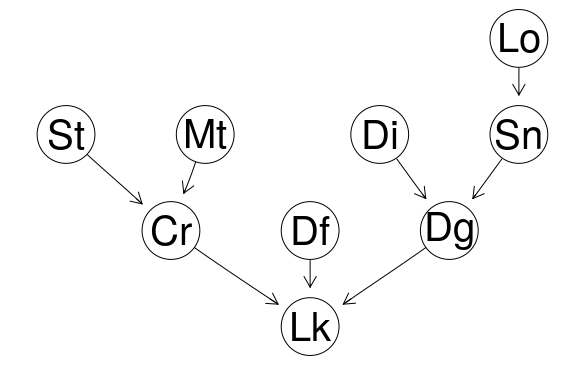

In [6]:
# Display image of Bayesian network 
from IPython.display import Image
print('Bayesian network Structure')
Image(filename='bn_dag.png') 


In [7]:
## Variable states
state_names = {'St': ("dolomite", "regular"),'Mt': ("ACD", "HDPE", "steel","Upvc"),'Cr':("Yes", "No"),
               'Df':(True, False),'Lo':("Erf", "Exit"),'Sn':("NoStrain","Low","High"),'Di':("Small", "Medium", "Large"),
               'Dg':("Yes", "No"),'Lk':("Positive", "Negative")}

In [8]:
Prior_Dirparams = {'St': np.ones((2,1)),'Mt' : np.ones((4,1)), 'Cr': np.ones((2,8)),'Df': np.ones((2,1)),'Lo': np.ones((2,1)),
          'Sn':np.ones((3,2)),'Di':np.ones((3,1)),'Dg':np.ones((2,9)) ,'Lk': np.ones((2,8))}

In [10]:
#Prior_Dirparams

# Working on the updating part

## Data based updating of BN_model

In [9]:
#Split update points
# Splitting the main data frame into smaller batches for the updating steps
# each patch comprise approximately k data point
k = 1000
data_split = np.array_split(df, len(df)/k)
print(len(data_split))

1000


In [10]:
# Much smaller and fairly good improvement for previous version
upd_priors = {}
upd_posterior = {}
Prior_Dirparams = {'St': np.ones((2,1)),'Mt' : np.ones((4,1)), 'Cr': np.ones((2,8)),'Df': np.ones((2,1)),'Lo': np.ones((2,1)),
          'Sn':np.ones((3,2)),'Di':np.ones((3,1)),'Dg':np.ones((2,9)) ,'Lk': np.ones((2,8))}
for i in range(len(data_split)):
    prior = Prior_Dirparams
    upd_priors.update({i:prior}) #holding k-1 updated parameters 'final posterior to be accesed from Prior_Dirparams
    # model fitting and counts obtaining
    #Since model counts are the ones of interest in terms of parameter updating
    #We only use model.fit to obtain the model most recently estimated
    model.fit(data_split[i],estimator = BayesianEstimator, prior_type="dirichlet",state_names = state_names, pseudo_counts=prior)
    #
    estimator = ParameterEstimator(model, data_split[i], state_names = state_names) # fitting model for obtaining counts only
    Post={}
    for ky in Prior_Dirparams.keys():
        Post.update({ky:estimator.state_counts(ky).values + Prior_Dirparams[ky]})
    #updating to posterior
    upd_posterior.update({i:Post})
    Prior_Dirparams = Post
    #print(model.get_cpds(node='St').values)
    

In [20]:
# specify parameter dictionary with all parameters Dirichlet prior parameters
def dir_sampler(upd_posterior,node_name = 'St', n = 1000):
    '''sampling from posterior distribution for the whole cpt each parameter with n samples
    Input: 
    Dir_params = an array of shape (updates,k,n,l)
    n = number of samples to be generated for each cpd
    k = dimension of cpd "possible joint over parents possible outcomes" k=1 for rootnode.
    l = possible outcomes of child node   
    Output:
    ndarray containing posterior's for each parameter, each with n samples
    '''
    post_dir = upd_posterior[0][node_name]
    #n = 1000
    cpt_param_upd = np.zeros((len(upd_posterior.keys()),post_dir.shape[1],n,post_dir.shape[0]))
    for j in range(len(upd_posterior.keys())): # looping over the update moments
        post_dir_params = upd_posterior[j][node_name]
        cpt_lk = np.zeros((post_dir_params.shape[1], n ,post_dir_params.shape[0])) #dim3
        st = post_dir_params.T
        for i in range(st.shape[0]):
            cpt_lk[i] = np.random.dirichlet(st[i].flatten(), n) #Generating n random samples for  multinomial over parents instatiation
        cpt_param_upd[j] = cpt_lk    
    return np.around(cpt_param_upd, decimals=3)

In [21]:
# input from function above
def plot(cpt_param_upd,child_instatiation = 0,Parent_instatiation = 0):
    #child_instatiation = 0 # You can adjust child instatiations (0=neg,1=pos)
    #Parent_instatiation = 7 # Different joint parent instatiations
    Lb = [np.percentile(cpt_param_upd[i,Parent_instatiation,:,child_instatiation], 2.5) for i in range(cpt_param_upd.shape[0])]
    Ub = [np.percentile(cpt_param_upd[i,Parent_instatiation,:,child_instatiation], 97.5) for i in range(cpt_param_upd.shape[0])]
    x = [i for i in range(cpt_param_upd.shape[0])]
    plt.fill_between(x, Lb, Ub, alpha=0.2, color='tab:blue')
    plt.plot([cpt_param_upd[i,Parent_instatiation,:,child_instatiation].mean() for i in range(cpt_param_upd.shape[0])],label = 'parameter_evolution')

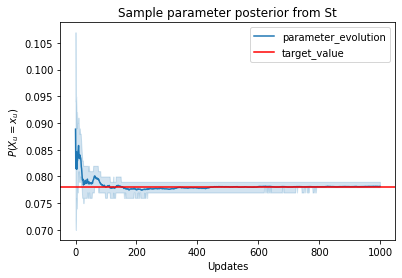

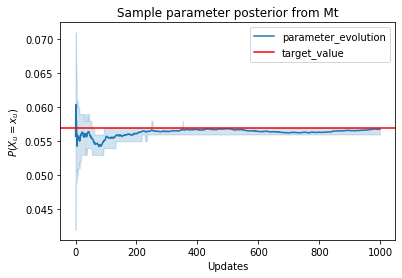

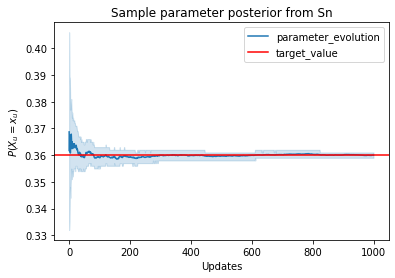

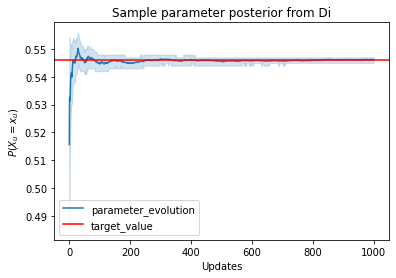

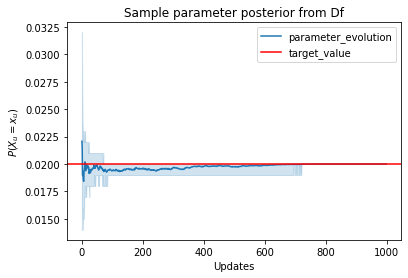

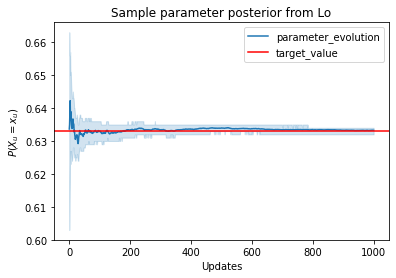

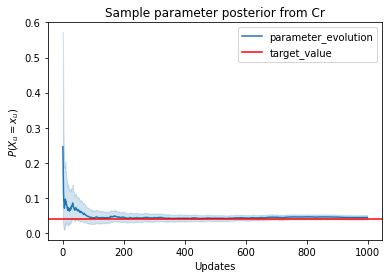

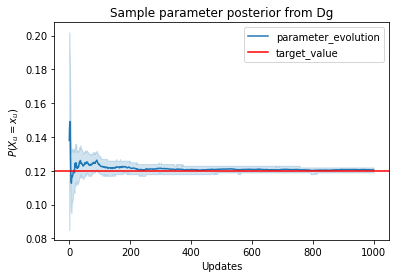

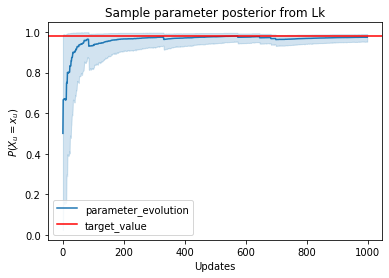

In [22]:
#post_dist_tables = [Dir_parms_st,Dir_parms_mt,Dir_parms_sn, Dir_parms_di,Dir_parms_df,Dir_parms_lo,
                    #Dir_parms_cr, Dir_parms_dg,Dir_parms_lk]

post_dist_table_names = ['St','Mt','Sn','Di','Df','Lo','Cr','Dg','Lk']
target_parameter_values=[0.078,0.057,0.36,0.546,0.02,0.633,0.04,0.12,0.98]
for i in range(len(post_dist_table_names)):
    plot(dir_sampler(upd_posterior, node_name = post_dist_table_names[i], n = 10000))
    plt.axhline(target_parameter_values[i], color="Red",label = 'target_value')
    plt.xlabel('Updates')
    plt.ylabel('$P(X_u=x_u)$')
    plt.title(f'Sample parameter posterior from {post_dist_table_names[i]}')
    plt.legend()
    plt.show()

In [118]:
# Parameter analysis
# Is the targate parater value held in the 95 percent credible interval?

# Slice a histogram at some iteration point. We can do it for the first iteration

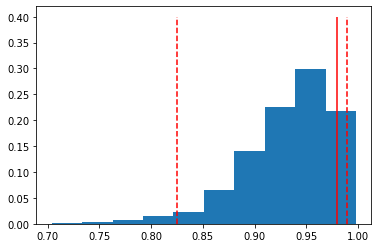

In [173]:
# plot a histogram for the posterior distribution of the model parameters
post_distribution = dir_sampler(upd_posterior, node_name ='Lk', n = 1000)[0,0,:,0]
LI = np.percentile(dir_sampler(upd_posterior, node_name ='Lk', n = 1000)[0,0,:,0],2.5)
UI = np.percentile(dir_sampler(upd_posterior, node_name ='Lk', n = 1000)[0,0,:,0],97.5)
weights = np.ones_like(post_distribution)/float(len(post_distribution))
plt.hist(post_distribution, weights=weights)
plt.vlines(LI,ymin = 0 ,ymax= .4,colors='red',linestyles='dashed')
plt.vlines(UI,ymin = 0 ,ymax=.4,colors='red',linestyles='dashed')
plt.vlines(0.98,ymin = 0 ,ymax=.4,colors='red',linestyles='solid')


In [175]:
len(dir_sampler(upd_posterior, node_name ='Lk', n = 1000))

10

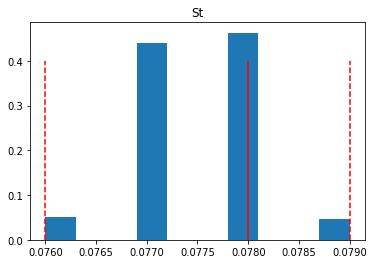

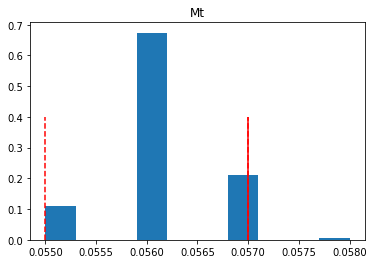

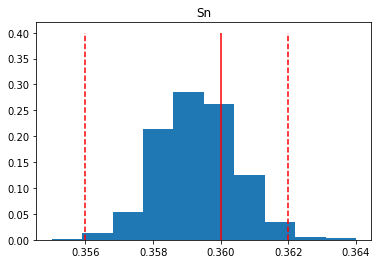

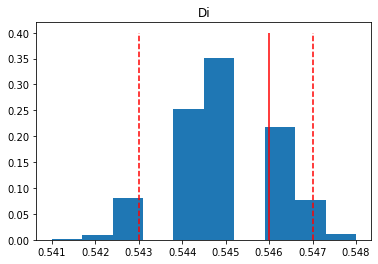

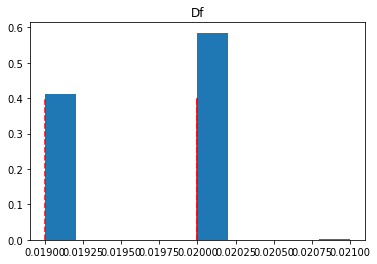

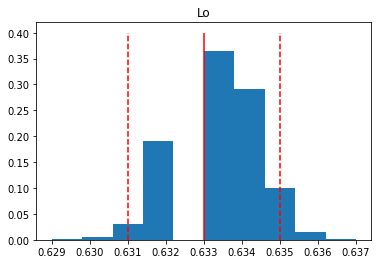

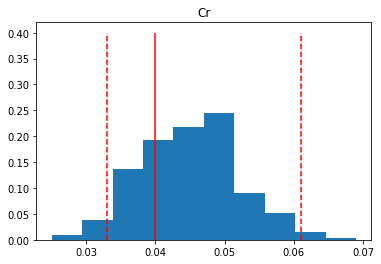

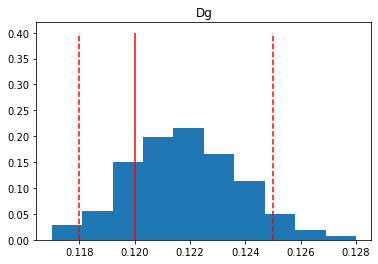

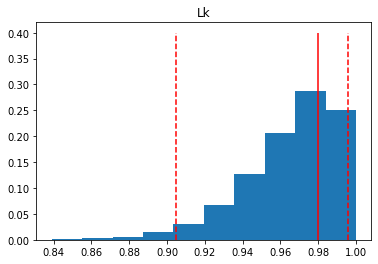

In [190]:
# sample posterior per node
post_dist_table_names = ['St','Mt','Sn','Di','Df','Lo','Cr','Dg','Lk']
target_parameter_values=[0.078,0.057,0.36,0.546,0.02,0.633,0.04,0.12,0.98]
for i in range(len(post_dist_table_names)):
    # plot a histogram for the posterior distribution of the model parameters
    post_distribution = dir_sampler(upd_posterior, node_name =post_dist_table_names[i], n = 1000)[1,0,:,0]
    LI = np.percentile(dir_sampler(upd_posterior, node_name =post_dist_table_names[i], n = 1000)[1,0,:,0],2.5)
    UI = np.percentile(dir_sampler(upd_posterior, node_name =post_dist_table_names[i], n = 1000)[1,0,:,0],97.5)
    weights = np.ones_like(post_distribution)/float(len(post_distribution))
    plt.hist(post_distribution, weights=weights)
    #plt.xlim(0.06,0.1)
    plt.title(f'{post_dist_table_names[i]}')
    plt.vlines(LI,ymin = 0 ,ymax= .4,colors='red',linestyles='dashed')
    plt.vlines(UI,ymin = 0 ,ymax=.4,colors='red',linestyles='dashed')
    plt.vlines(target_parameter_values[i],ymin = 0 ,ymax=.4,colors='red',linestyles='solid')
    plt.show()

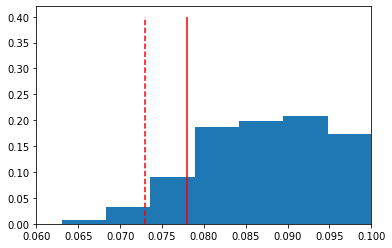

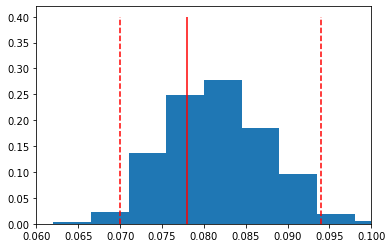

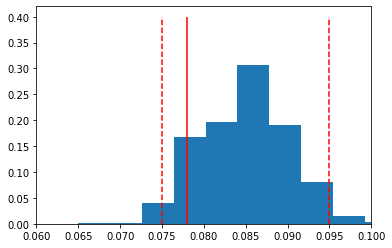

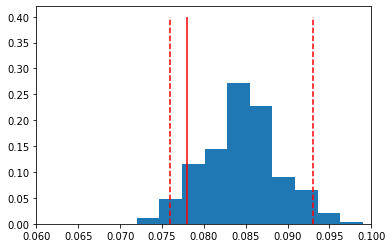

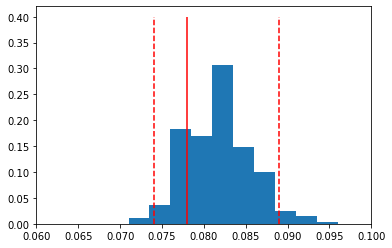

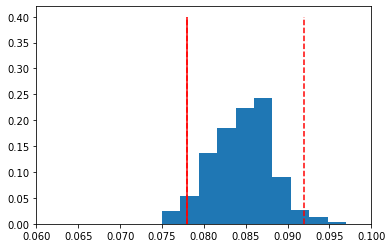

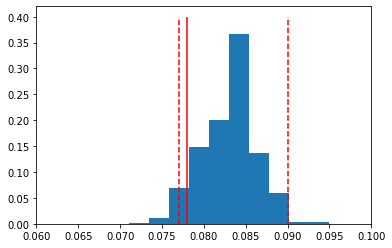

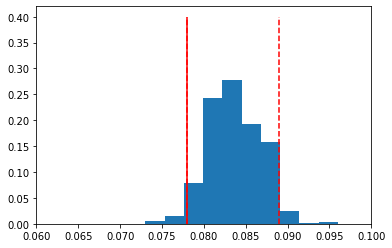

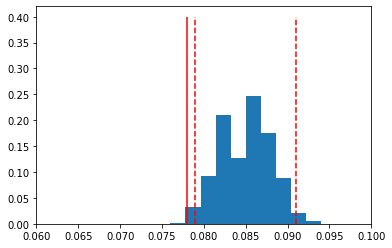

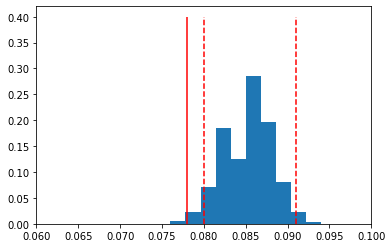

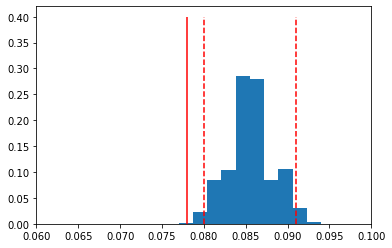

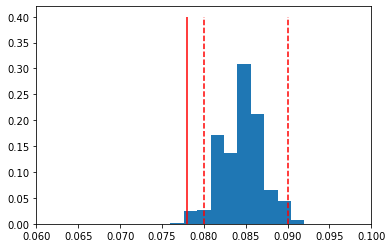

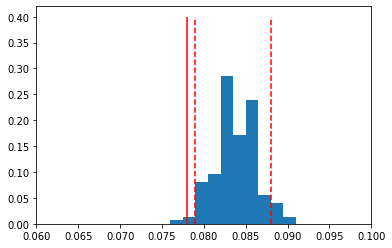

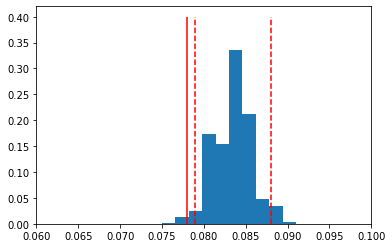

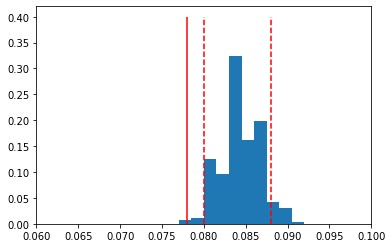

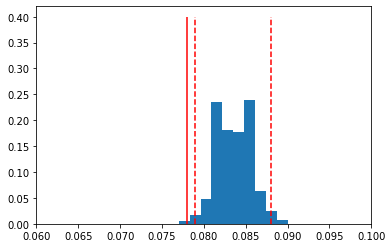

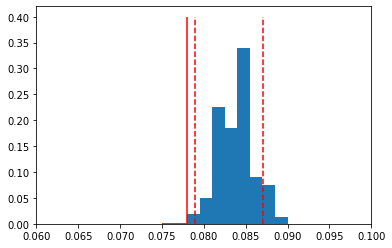

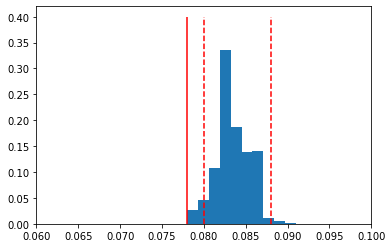

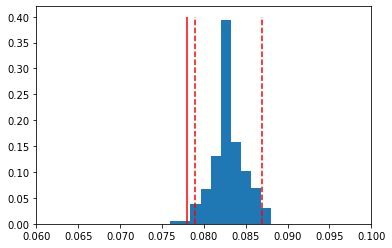

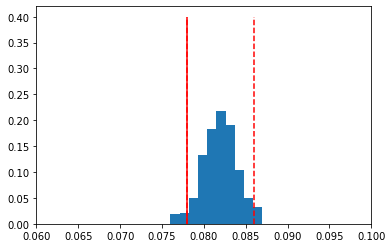

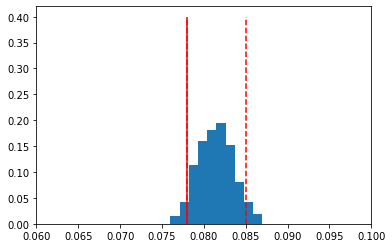

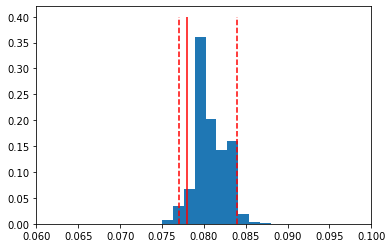

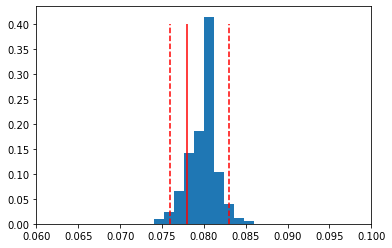

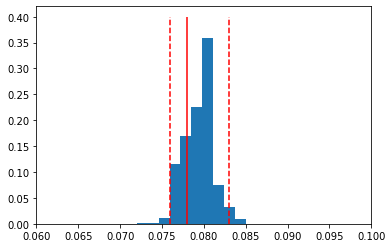

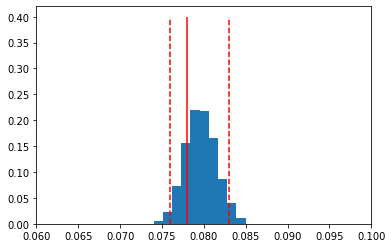

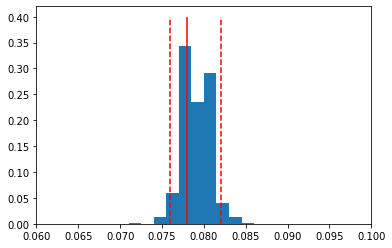

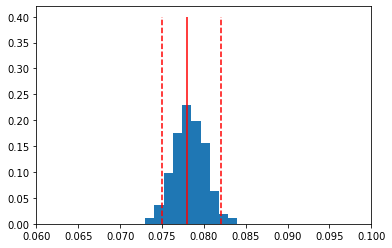

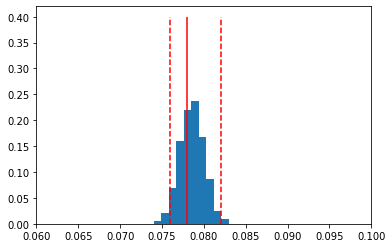

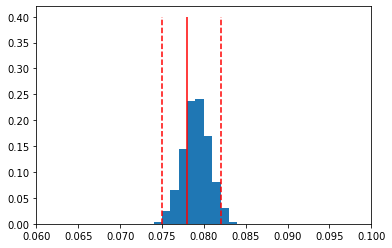

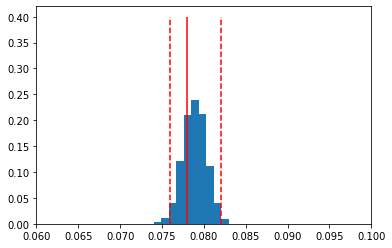

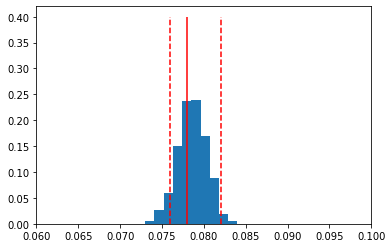

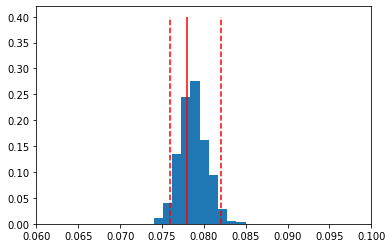

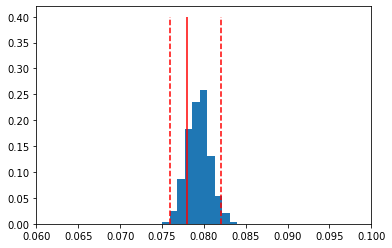

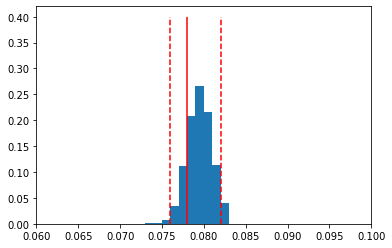

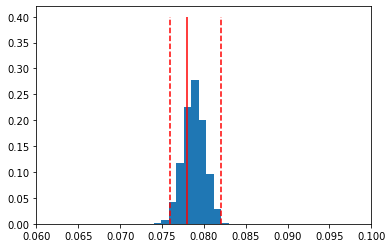

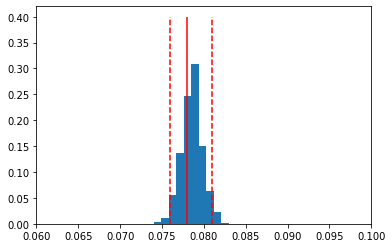

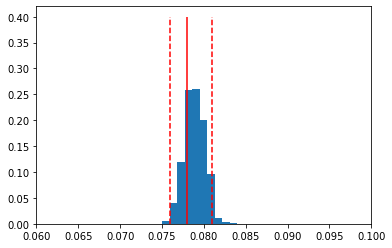

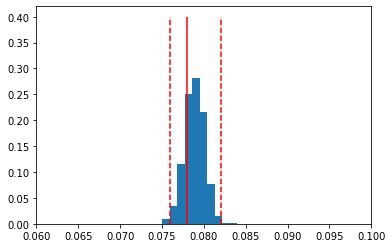

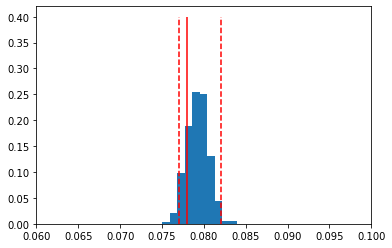

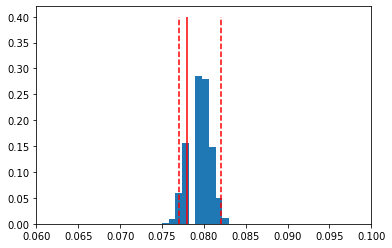

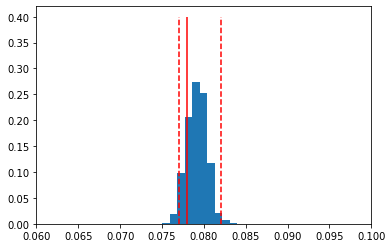

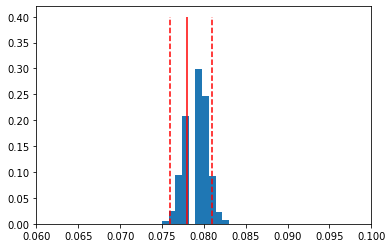

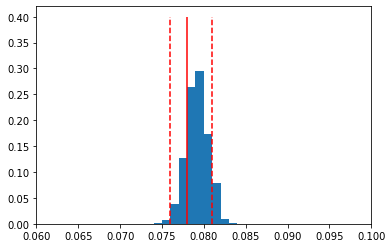

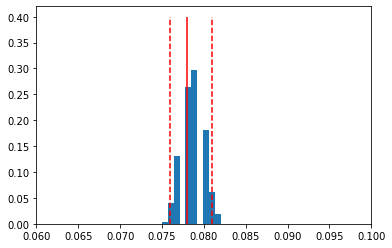

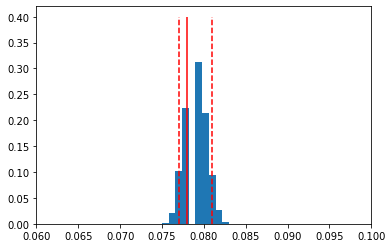

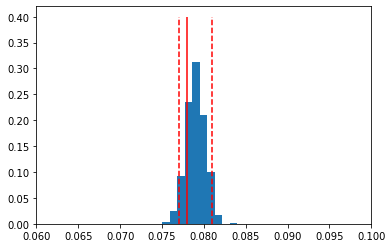

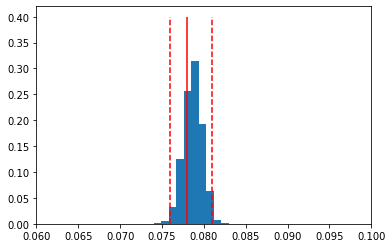

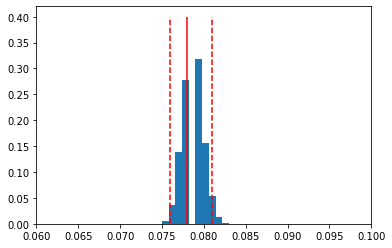

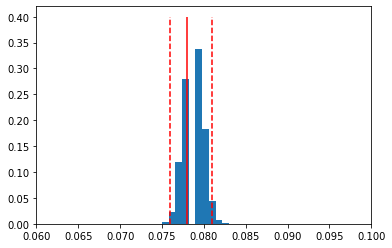

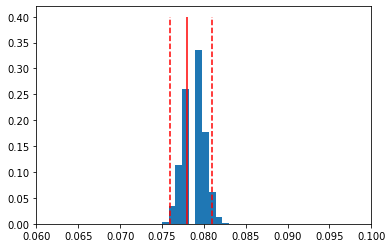

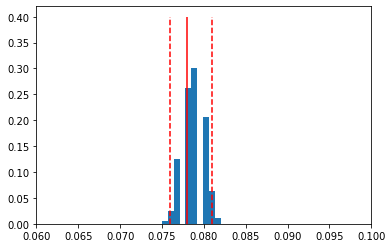

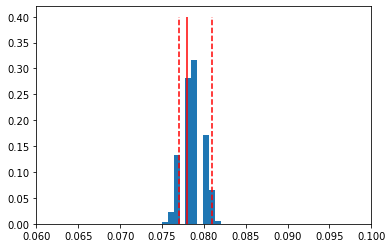

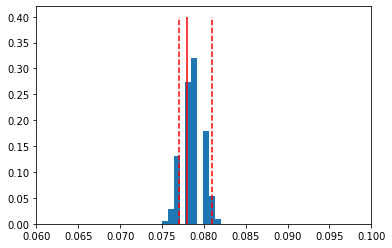

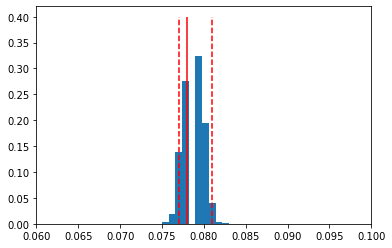

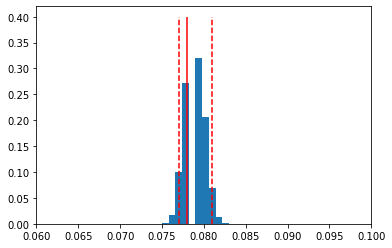

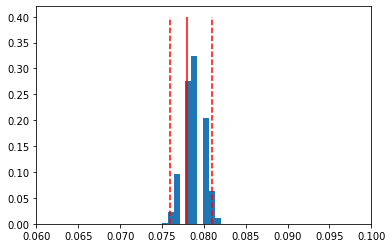

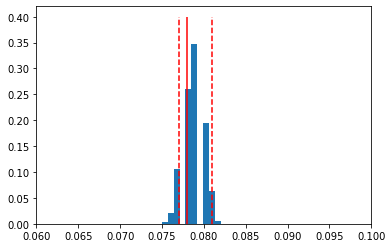

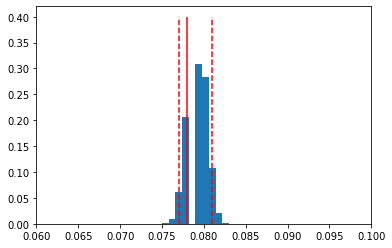

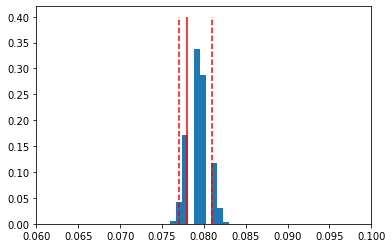

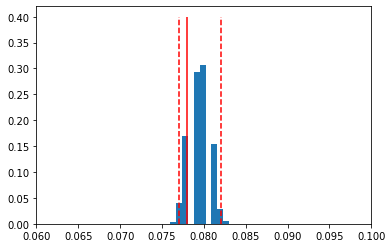

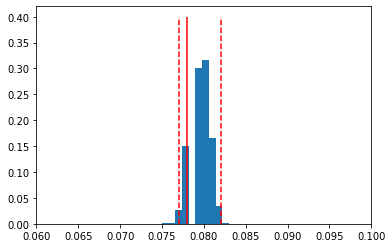

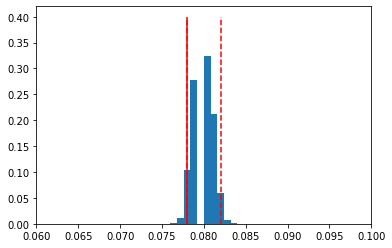

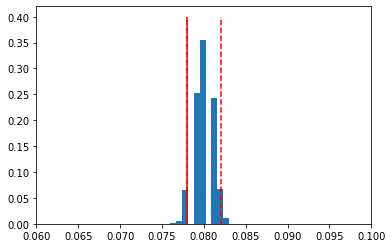

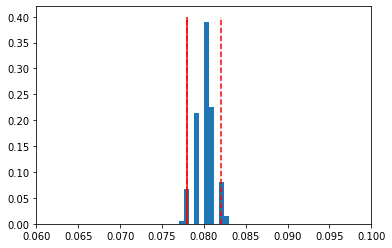

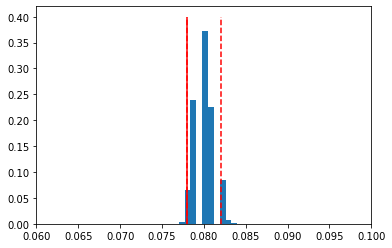

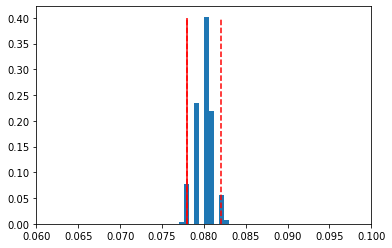

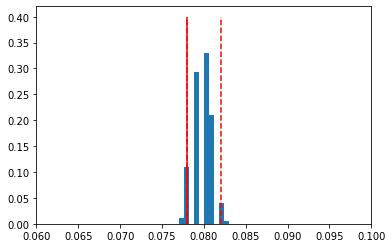

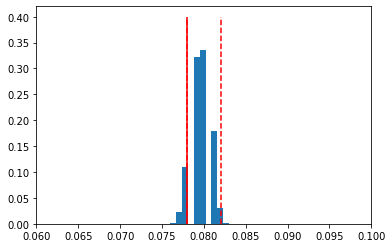

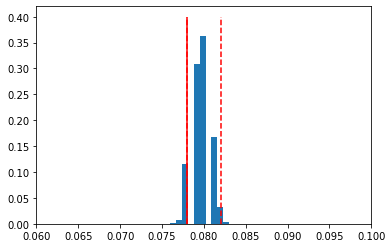

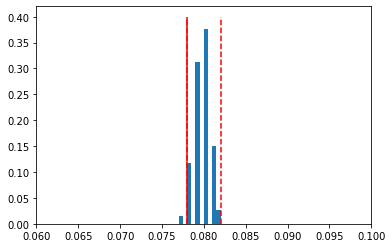

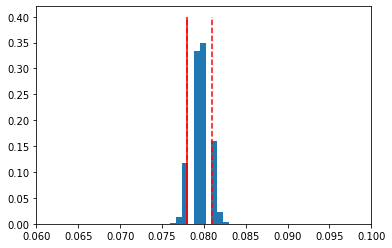

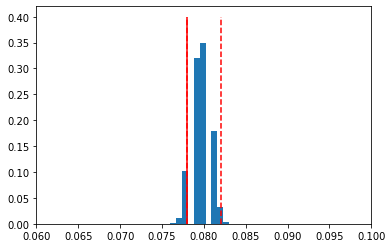

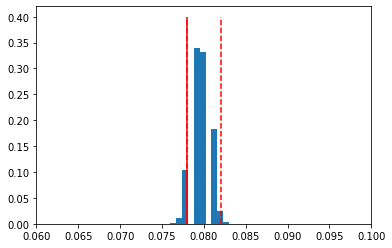

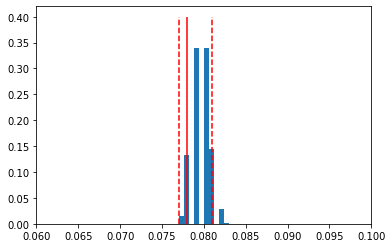

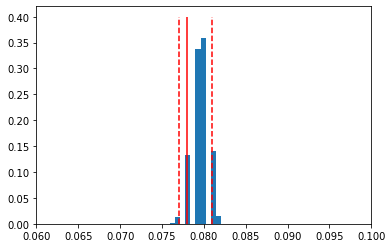

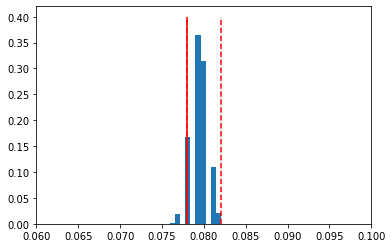

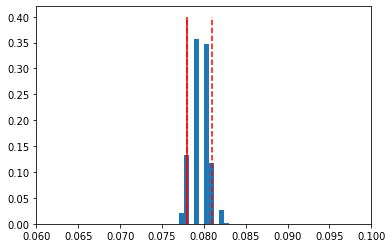

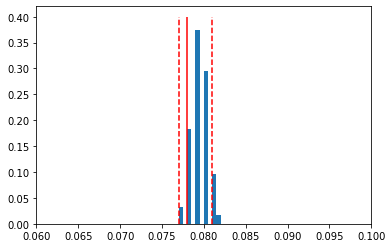

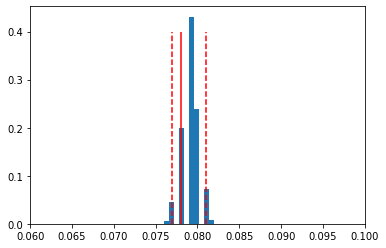

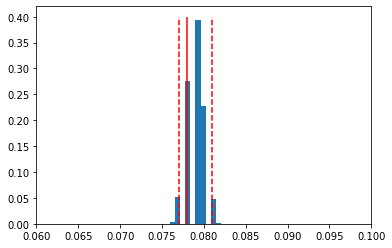

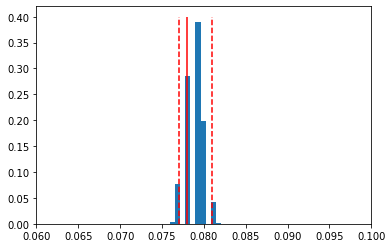

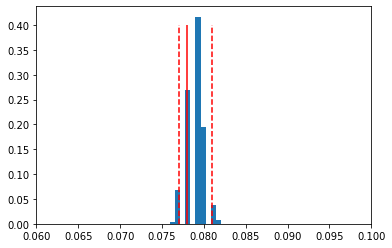

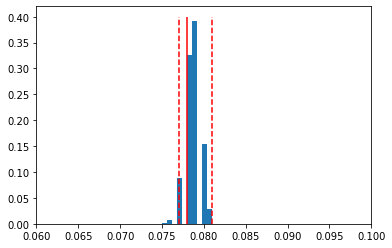

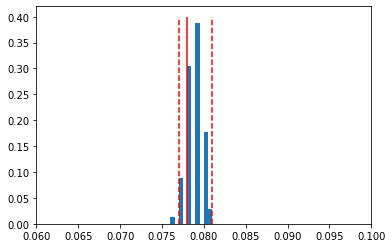

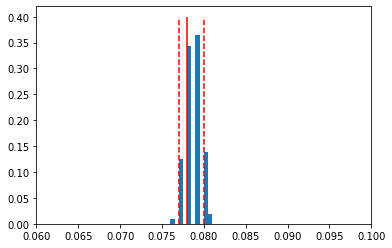

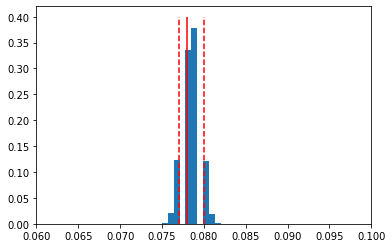

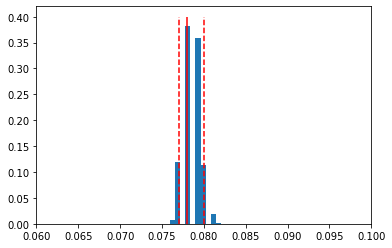

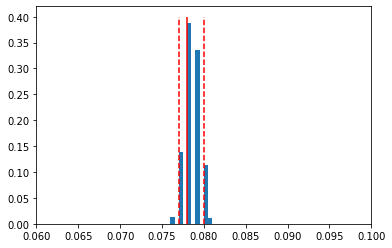

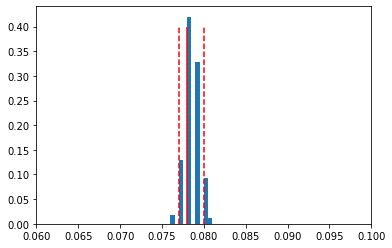

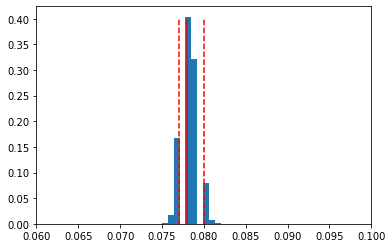

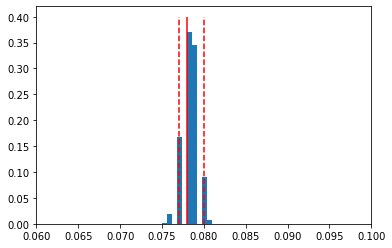

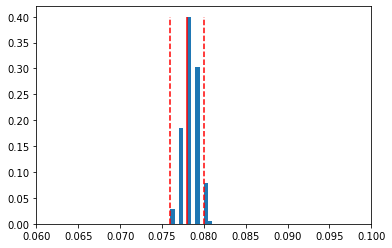

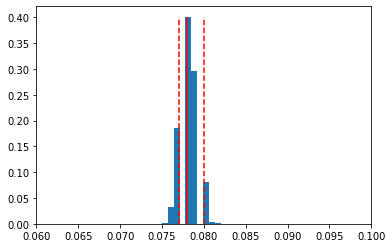

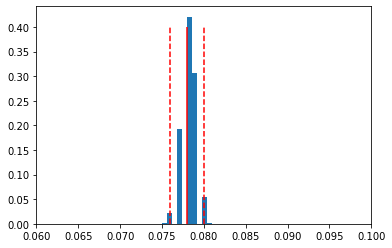

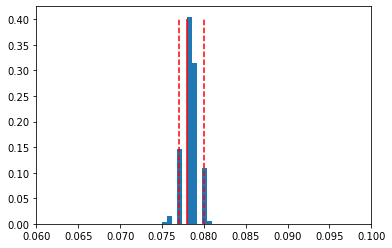

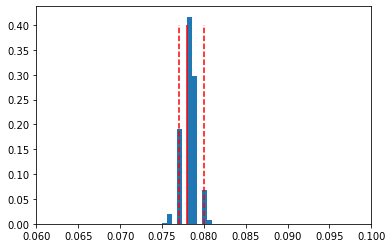

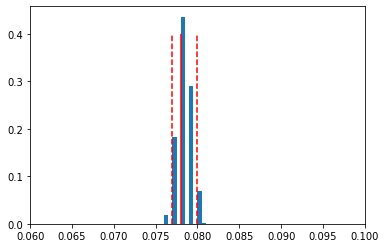

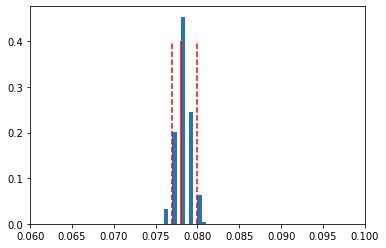

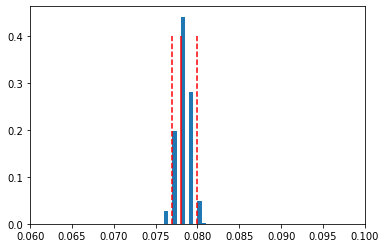

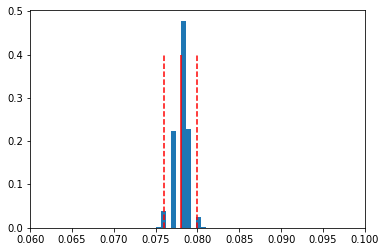

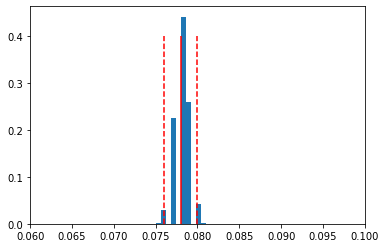

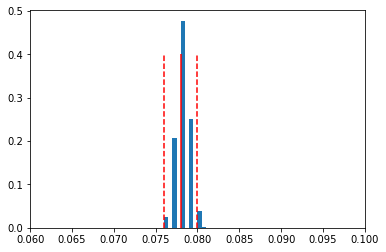

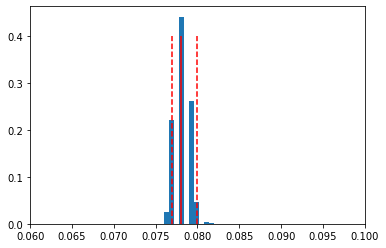

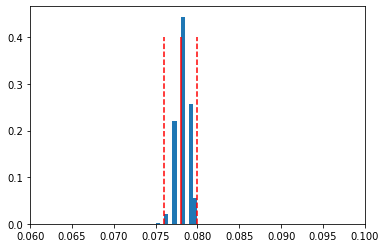

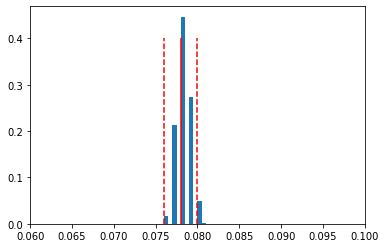

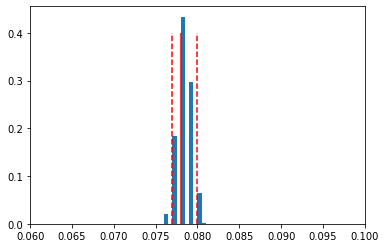

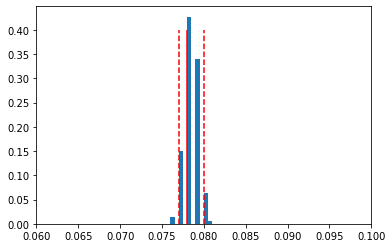

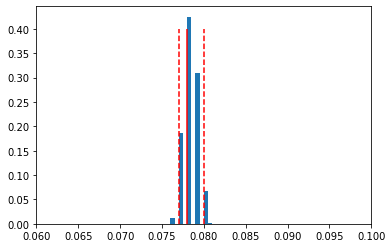

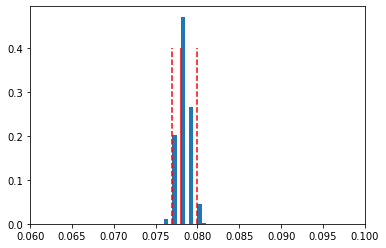

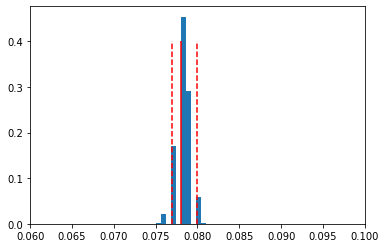

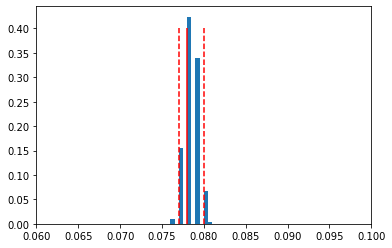

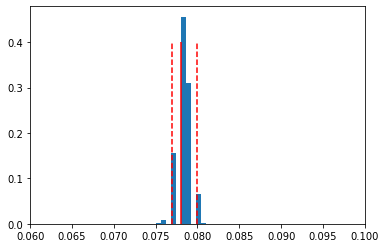

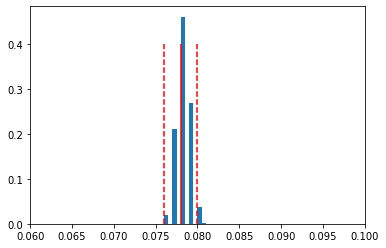

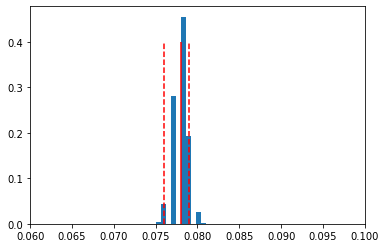

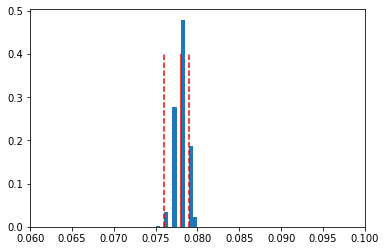

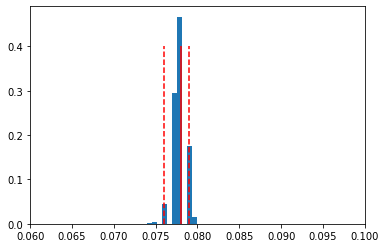

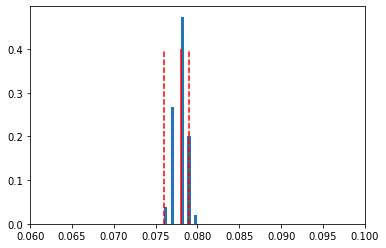

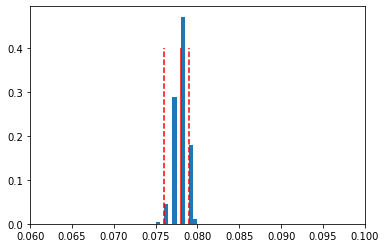

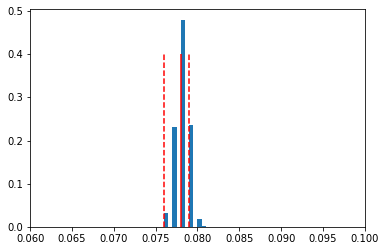

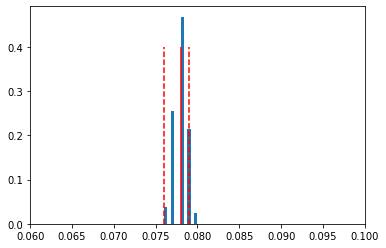

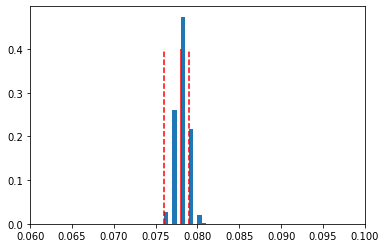

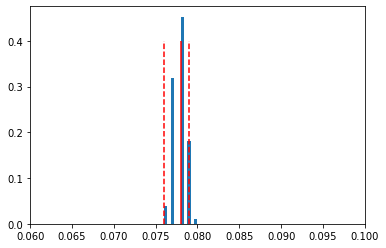

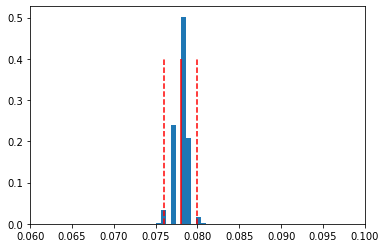

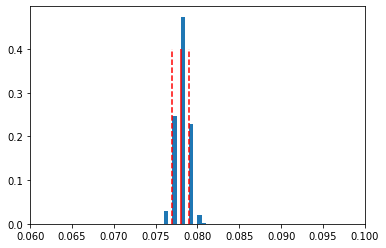

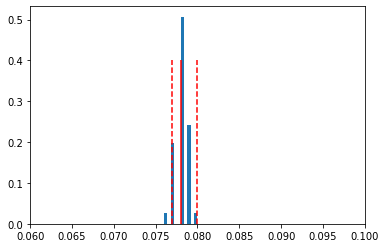

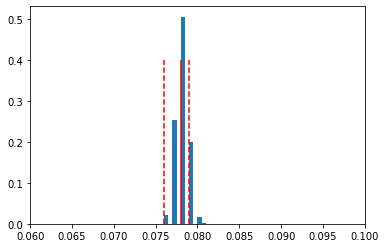

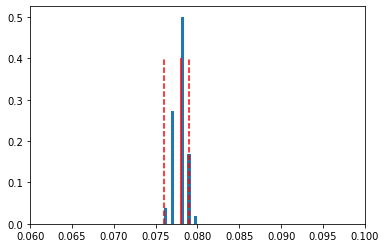

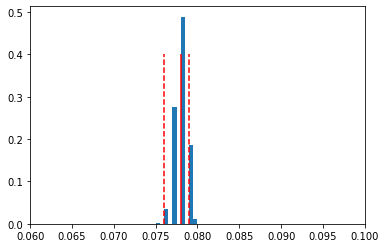

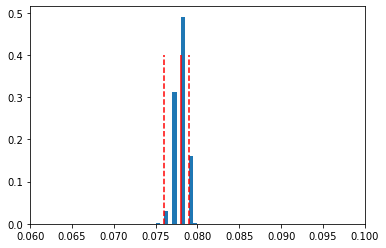

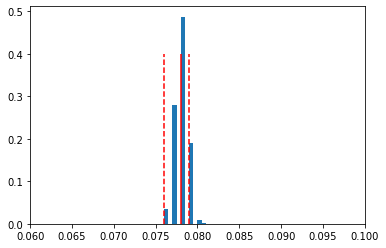

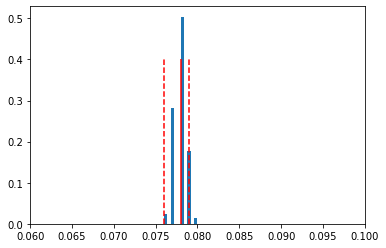

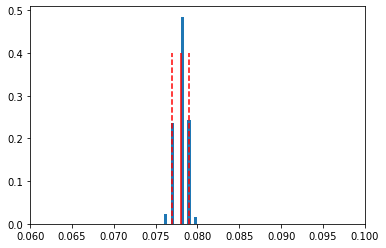

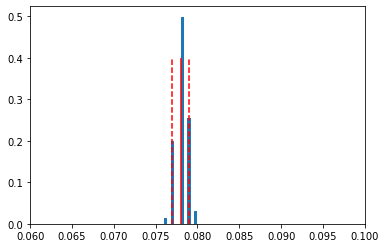

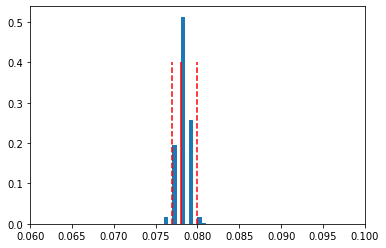

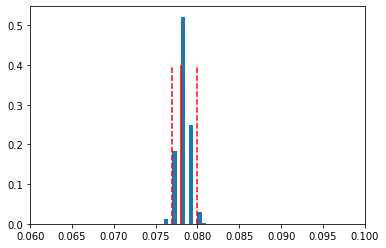

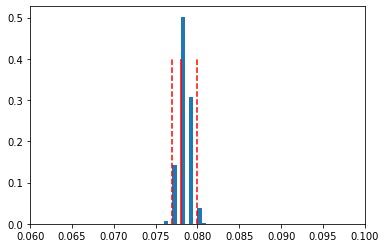

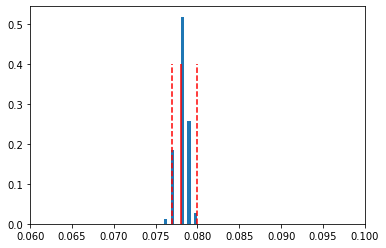

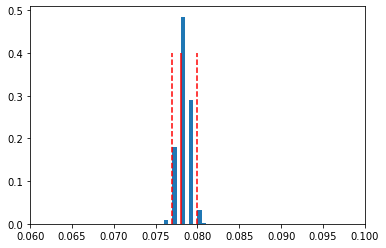

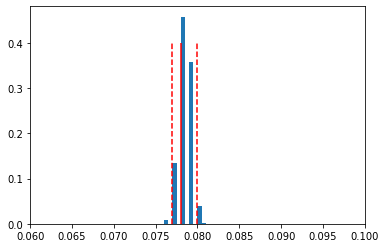

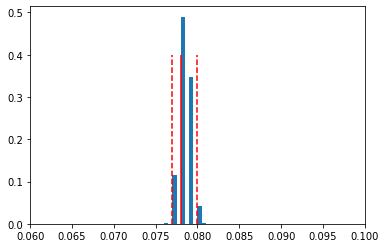

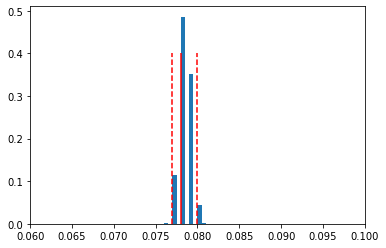

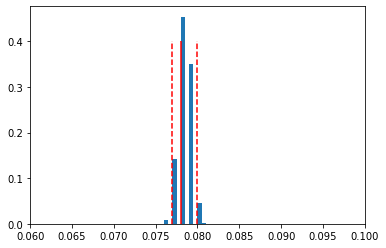

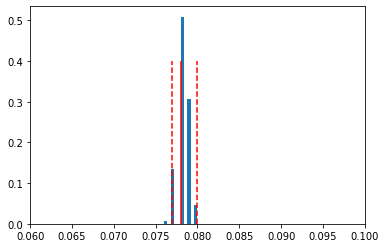

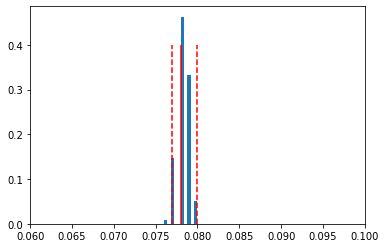

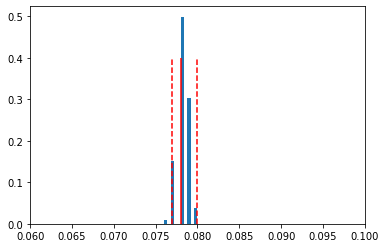

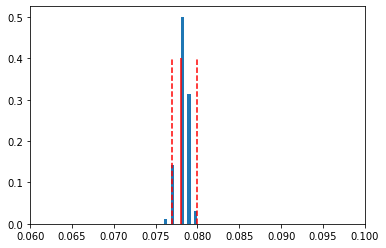

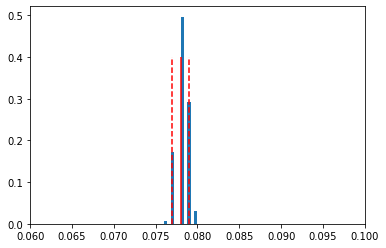

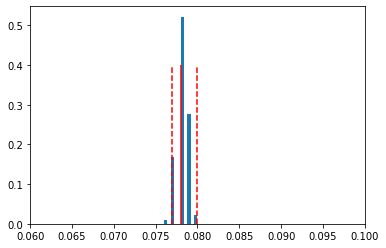

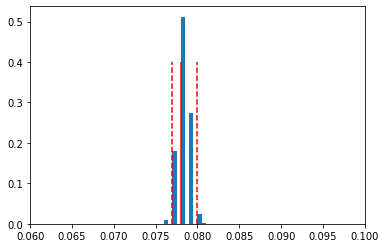

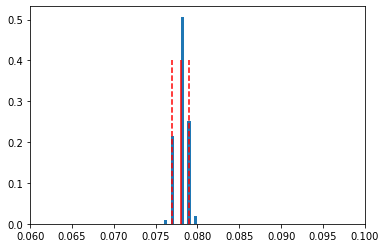

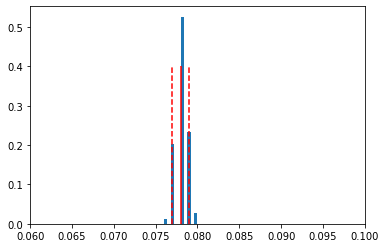

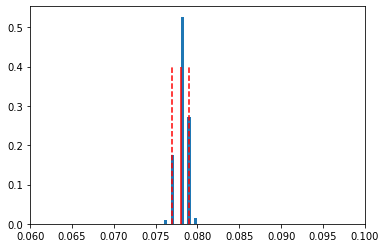

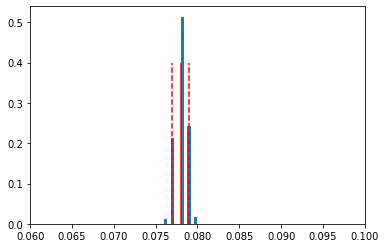

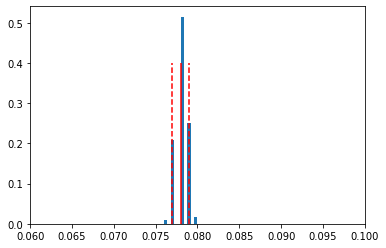

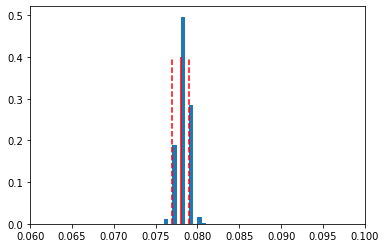

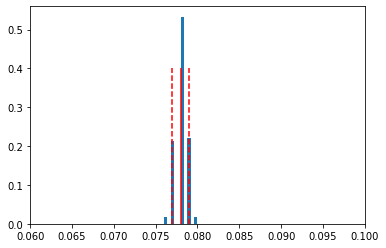

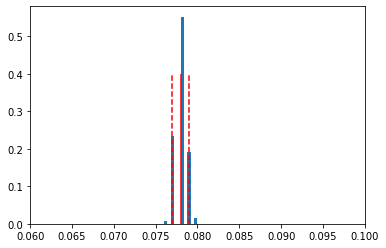

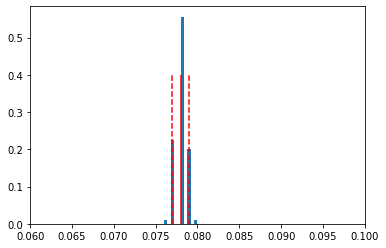

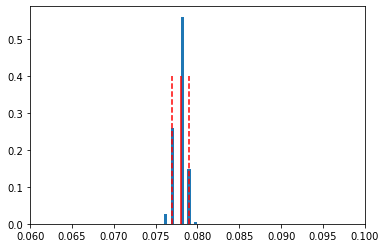

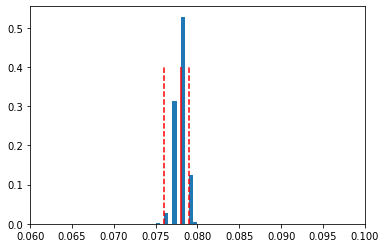

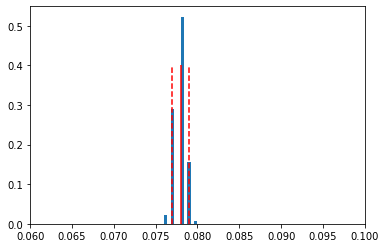

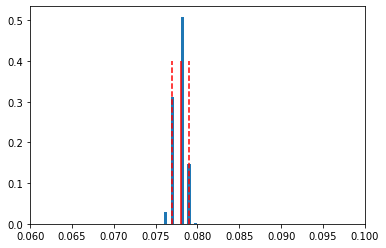

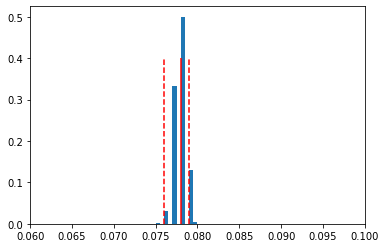

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [19]:
#Evoluiton of distribution with more observations
for i in range(len(dir_sampler(upd_posterior, node_name ='St', n = 1000))):
    # plot a histogram for the posterior distribution of the model parameters
    post_distribution = dir_sampler(upd_posterior, node_name ='St', n = 1000)[i,0,:,0]
    LI = np.percentile(dir_sampler(upd_posterior, node_name ='St', n = 1000)[i,0,:,0],2.5)
    UI = np.percentile(dir_sampler(upd_posterior, node_name ='St', n = 1000)[i,0,:,0],97.5)
    weights = np.ones_like(post_distribution)/float(len(post_distribution))
    plt.hist(post_distribution, weights=weights)
    plt.xlim(0.06,0.1)
    plt.vlines(LI,ymin = 0 ,ymax= .4,colors='red',linestyles='dashed')
    plt.vlines(UI,ymin = 0 ,ymax=.4,colors='red',linestyles='dashed')
    plt.vlines(0.078,ymin = 0 ,ymax=.4,colors='red',linestyles='solid')
    plt.show()

# Might be of use code 

# Inference in Bayesian networks

In [25]:
#bayesNet.check_model()
#print("Model is correct."#

In [ ]:
#model.update()

In [26]:
model.check_model()

True

##### Of interest in this study is the answer to the  inference  question, given what we observe on a pipe based in relation to the model variables what is the likelihood of the pipe having a leakage?
That is; $$P(Lk=Positive|St=st,Cr=cr,Mt=mt,Di=di,Dg=dg,Sn=sn,Lo=lo,Lk=lk,Df=df)$$
We use variable elimination algorithm to achieve this;

In [27]:
# Variable Elimination solver
solver = VariableElimination(model)

In [246]:
# Network nodes with their states for reference
solver.state_names_map

{'St': {0: 'dolomite', 1: 'regular'},
 'Cr': {0: 'Yes', 1: 'No'},
 'Mt': {0: 'ACD', 1: 'HDPE', 2: 'steel', 3: 'Upvc'},
 'Di': {0: 'Small', 1: 'Medium', 2: 'Large'},
 'Dg': {0: 'Yes', 1: 'No'},
 'Sn': {0: 'NoStrain', 1: 'Low', 2: 'High'},
 'Lo': {0: 'Erf', 1: 'Exit'},
 'Lk': {0: 'Positive', 1: 'Negative'},
 'Df': {0: True, 1: False}}

In [29]:
##Assume a pipe with the following conditions
#St = dolomite, Mt = HDPE, Di = medium, Lo = exit,Df=False
evidence = {'St':0, 'Mt':1, 'Di':0, 'Lo':1,'Df':1,'Dg':1}
result = solver.query(variables=['Lk'], evidence=evidence)
print(result)

Eliminating: Sn: 100%|██████████| 2/2 [00:00<00:00, 371.56it/s]

+--------------+-----------+
| Lk           |   phi(Lk) |
+==============+===========+
| Lk(Positive) |    0.0202 |
+--------------+-----------+
| Lk(Negative) |    0.9798 |
+--------------+-----------+


##  Evaluations

In [30]:
# Simulated data

In [31]:
test = pd.read_csv('test_wdssimulated_data.csv').drop('Unnamed: 0', axis = 1)
#test.columns

In [32]:
y_true = test['Lk']

In [33]:
X_test = test.drop('Lk', axis = 1)

In [34]:
y_pred = model.predict(X_test)

100%|██████████| 382/382 [00:04<00:00, 91.40it/s] 


In [39]:
con_matrix = confusion_matrix(y_true, y_pred)# Accuracy
con_matrix

array([[7478, 1244],
       [  11, 1267]])

In [40]:
Accuracy = accuracy_score(y_true, y_pred)
Accuracy

0.8745

In [41]:
recall = recall_score(y_true, y_pred, average=None)
recall

array([0.857, 0.991])

In [42]:
precision = precision_score(y_true, y_pred, average=None)
precision

array([0.999, 0.505])

## How sensitive are our inferences to changes in node values?

In [ ]:
# Sensitivity analysis using odds ratio. 
#To assess the possible impacts of changing a node variables value to check how each single variable affects the probability
# of observing a leakage event. Helping to get a sense of how each node can independently affect the probability of a 
# leak event.
# We compute the odds of a leak based on each value instantiation of each dependent variable.
# We then take the difference between the maximum and minimum Odds from all possible node values giving a range of 
#the change in the Odds of observing a leak event. The bigger the change the more sensitive leak probabilities are to 
#that node.

In [366]:
#Must be moved to functions
def odds_compute(solver,target_variable_name):
    ''' Input :
            Solver =  a variable elimination object defined on a fully defined Bayesian network
            target_variable_name = the name of the node for which you want to check the impacts of every other single node
        Output: 
            dictionary whose keys are network nodes and values are 2d lists containing node value name and corresponding
            Odds ratio for the occurence of a leak event if the node where in that state holding all other nodes equal'''
    tst = solver.state_names_map
    odds_dict = dict()
    for node in (set(tst.keys()) - {target_variable_name}):
        col = []
        for i in range(len(tst[node].keys())):
            result = solver.query(variables=[target_variable_name], evidence={node:i})
            #result = solver.query(variables=['Lk'], evidence={'Dg':i})
            odds = result.values[0]/(1-result.values[0])
            col.append([node,tst[node][i],odds])
        odds_dict.update({node:col})
    return odds_dict

In [367]:
odds_dict = odds_compute(solver,'Lk')

Eliminating: Df: 100%|██████████| 7/7 [00:00<00:00, 406.30it/s]


In [369]:
odds_dict.keys()

dict_keys(['Di', 'St', 'Sn', 'Mt', 'Lo', 'Dg', 'Df', 'Cr'])

In [372]:
def odds_change_range(solver,target_variable_name):    
    odds_dict = odds_compute(solver,target_variable_name)
    frame = []
    for node in odds_dict.keys():  
        lst = odds_dict[node]
        frame.append(pd.DataFrame(lst, columns =['Node','Value', 'Odds'],dtype = float))  
    Odds_sensitivity = pd.concat(frame)
    Odds_max = Odds_sensitivity.groupby(['Node']).max()
    Odds_max = Odds_max.rename(columns={'Odds':'Max_Odds'})
    Odds_min = Odds_sensitivity.groupby(['Node']).min()
    Odds_min = Odds_min.rename(columns={'Odds':'Min_Odds'}).drop('Value',axis = 1)
    min_max = pd.concat([Odds_max, Odds_min], axis=1, join='inner')
    min_max['Odds_diff'] = min_max['Max_Odds'] - min_max['Min_Odds']
    return min_max

In [374]:
target_odds_change = odds_change_range(solver,'Lk')

Eliminating: Df: 100%|██████████| 7/7 [00:00<00:00, 373.36it/s]


In [375]:
# The larger the difference the more sensitive Lk is to the change of values in that node under variable elimination 
# framework

target_odds_change

,Value,Max_Odds,Min_Odds,Odds_diff
Node,,,,
Cr,Yes,0.168031,0.149108,0.018923
Df,1,0.182380,0.149552,0.032828
Dg,Yes,1.015294,0.001094,1.014200
Di,Small,0.178398,0.099460,0.078938
Lo,Exit,0.261304,0.094351,0.166952
Mt,steel,0.154190,0.149108,0.005082
Sn,NoStrain,0.410693,0.041946,0.368747
St,regular,0.150267,0.149267,0.001000


## Posterior predictive distribution


$P(Lk = s|D) = \frac{\alpha '_{s}}{\sum_{j=1}^{k} \alpha '_{j}}$

In [65]:
alpha_pos = sum(Prior_Dirparams['Lk'][0])

In [66]:
alpha_neg = sum(Prior_Dirparams['Lk'][1])

In [67]:
post_pred = [alpha_pos/(alpha_pos+alpha_neg),alpha_neg/(alpha_pos+alpha_neg)]

In [68]:
post_pred 

[0.13056191100942385, 0.8694380889905762]

In [69]:
# Error on the posterior prediction distribution
sigma_post_pred = post_pred[0]*post_pred[1]

In [70]:
sigma_post_pred

0.11351549840299115

# Posterior predictive distribution on query posterior 

In [15]:
# Defining the model structure. We can define the network by just passing a list of edges.
model1 = BayesianModel([('St', 'Cr'), ('Mt', 'Cr'), ('Di', 'Dg'), ('Lo', 'Sn'), ('Sn', 'Dg'), ('Cr', 'Lk'), ('Dg', 'Lk'), ('Df', 'Lk')])


In [12]:
def cpt_sampler(node,dir_post_params):
    '''Given dirichlet posterior parameters this function is for sampling node cpt parameters
    input : 
            Node for which we want to get cpt
            Posterior parameter
    Output : Sample posterior cpt parameters given the posterior dirichlet parameter 
    '''
    dim = dir_post_params[100][node].shape # Change 100 index such that it represents the most recent updata
    cpt_sample_post = np.zeros(dim)
    for i in range(dim[1]):
        cpt_sample_post[:,i] = np.random.dirichlet(dir_post_params[100][node][:,i].flatten())
    return cpt_sample_post

In [26]:
# Defining single sample of cpds
St = cpt_sampler('St',upd_posterior)
Mt = cpt_sampler('Mt',upd_posterior)
Di = cpt_sampler('Di',upd_posterior)
Lo = cpt_sampler('Lo',upd_posterior)
Df = cpt_sampler('Df',upd_posterior)
Sn = cpt_sampler('Sn',upd_posterior)
Cr = cpt_sampler('Cr',upd_posterior)
Dg = cpt_sampler('Dg',upd_posterior)
Lk = cpt_sampler('Lk',upd_posterior)    
# Defining individual CPDs.
# The defined probabilities have to be difined as variables that are to be updated at every iteration

cpd_St = TabularCPD(variable='St', variable_card=2, values= St)
cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)
cpd_Mt = TabularCPD(variable='Mt', variable_card=4, values= Mt)
cpd_Di = TabularCPD(variable='Di', variable_card=3, values= Di)
#cpd_Lo = TabularCPD(variable='Lo', variable_card=2, values= Lo)
#cpd_Df = TabularCPD(variable='Df', variable_card=2, values= Df)

cpd_Sn = TabularCPD(variable='Sn', variable_card=3, 
                   values= Sn,                          
                  evidence=['Lo'],
                  evidence_card=[2])

cpd_Cr = TabularCPD(variable='Cr', variable_card=2, 
                   values=Cr,                          
                  evidence=['Mt','St'],
                  evidence_card=[2, 4])

cpd_Dg = TabularCPD(variable='Dg', variable_card=2, 
                   values=Dg,                          
                  evidence=['Di','Sn'],
                  evidence_card=[3, 3])
cpd_Lk = TabularCPD(variable='Lk', variable_card=2, 
                   values=Lk,                          
                  evidence=['Cr', 'Df','Dg'],
                  evidence_card=[2, 2, 2])
model1.add_cpds(cpd_St, cpd_Mt, cpd_Di, cpd_Lo, cpd_Sn, cpd_Df, cpd_Cr, cpd_Dg, cpd_Lk)
model1.check_model()


True

In [27]:
solver1 = Inference(model1)

In [28]:
solver1.variables()

NodeView(('St', 'Cr', 'Mt', 'Di', 'Dg', 'Lo', 'Sn', 'Lk', 'Df'))

In [17]:
print(cpd_St)

+-------+-----------+
| St(0) | 0.0768645 |
+-------+-----------+
| St(1) | 0.923136  |
+-------+-----------+


In [29]:
solver = VariableElimination(model1)

In [34]:
print(model1.get_cpds(node='Mt'))

+-------+-----------+
| Mt(0) | 0.0563092 |
+-------+-----------+
| Mt(1) | 0.34125   |
+-------+-----------+
| Mt(2) | 0.157235  |
+-------+-----------+
| Mt(3) | 0.445206  |
+-------+-----------+


In [24]:
St = cpt_sampler('St',upd_posterior)
St

array([[0.078],
       [0.922]])

In [35]:
# Network nodes with their states for reference
solver.state_names_map['St']

{0: 0, 1: 1, 2: 2, 3: 3}

In [259]:
##Assume a pipe with the following conditions
#St = dolomite, Mt = HDPE, Di = medium, Lo = exit,Df=False
evidence = {'Mt':1, 'Di':0, 'Lo':1,'Df':1,'Dg':0}
result1 = ty.query(variables=['Lk'], evidence=evidence)
print(result1)

Eliminating: St:  33%|███▎      | 1/3 [00:00<00:00, 192.30it/s]


ValueError: operands could not be broadcast together with shapes (4,2) (2,1) 

In [215]:
result1.values[0]

0.501321775993326

In [229]:
sample = [np.argmax(np.random.multinomial(1,(.2,.3,.3,.2),20)[i]) for i in range(20)]
#sample
lk_oc = []
for i in sample:
    result = solver.query(variables=['Lk'], evidence={'Mt':i})
    lk_oc.append(result.values[0])

Eliminating: Cr: 100%|██████████| 7/7 [00:00<00:00, 456.42it/s]


In [63]:
# testing it on Dirichlet parameters
# Variable Elimination solver
solver1 = VariableElimination(estimator)

AttributeError: 'ParameterEstimator' object has no attribute 'check_model'

In [79]:
estimator.state_counts('Lk')

Cr         Yes                     No                    
Df       True       False       True         False       
Dg         Yes   No   Yes    No   Yes    No    Yes     No
Lk                                                       
Positive   1.0  0.0  10.0   0.0   1.0   0.0  123.0    0.0
Negative   0.0  1.0  10.0  48.0   5.0  13.0  108.0  680.0

In [242]:
np.around(statistics.variance(lk_oc),decimals=7)

3.7e-06

In [ ]:
estimator.state_counts('Lk').T

In [ ]:
io = dir_sampler(upd_posterior, node_name ='Lk', n = 1000) # Sampled posterior estimate for the parameters after update